### Setup

In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

if not os.path.isdir('src'):
    !git init .
    !git remote add origin https://github.com/Manuel-Materazzo/Mental-Health.git

print('Pulling...')
!git pull origin master -q

print('Installing dependencies...')
!pip install -r /kaggle/working/src/requirements.txt -q

from src.enums.accuracy_metric import AccuracyMetric

from src.pipelines.mental_health_dt_pipeline import MentalHealthDTPipeline

from src.models.xgb_classifier import XGBClassifierWrapper

from src.trainers.accurate_cross_trainer import AccurateCrossTrainer
from src.trainers.cached_accurate_cross_trainer import CachedAccurateCrossTrainer

from src.hyperparameter_optimizers.optuna_optimizer import OptunaOptimizer
from src.hyperparameter_optimizers.custom_grid_optimizer import CustomGridOptimizer

pd.set_option('display.max_columns', None)

def load_data():
    # Load the data
    file_path = '/kaggle/input/playground-series-s4e11/train.csv'
    data = pd.read_csv(file_path, index_col='id')
    data = data.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
    
    # Remove rows with missing target, separate target from predictors
    data.dropna(axis=0, subset=['Depression'], inplace=True)
    y = data['Depression']
    data.drop(['Depression'], axis=1, inplace=True)
    data.drop(['Name'], axis=1, inplace=True)
    data.drop(['City'], axis=1, inplace=True)
    return data, y

print('Loading data...')
X, y = load_data()
print('Done ✅')

Initialized empty Git repository in /kaggle/working/.git/
Pulling...
Installing dependencies...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.1 requires botocore<1.35.24,>=1.35.16, but you have botocore 1.35.69 which is incompatible.
albucore 0.0.17 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.17 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 17.0.0 which is incompatible.
bayesian-optimization 1.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
beatrix-jupyterlab 2024.66.154055 req

## Explore Data

In [2]:
X.head()

,Gender,Age,Working_Professional_or_Student,Profession,Academic_Pressure,Work_Pressure,CGPA,Study_Satisfaction,Job_Satisfaction,Sleep_Duration,Dietary_Habits,Degree,Have_you_ever_had_suicidal_thoughts_,Work_Study_Hours,Financial_Stress,Family_History_of_Mental_Illness
id,,,,,,,,,,,,,,,,
0,Female,49.0,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No
1,Male,26.0,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No
2,Male,33.0,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No
3,Male,22.0,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes
4,Female,30.0,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes


In [3]:
# fast insights
print(f"There are {sum(X.duplicated())} duplicated rows in the train data frame.")

print('total columns: ', len(X.columns.values))

features_with_missing_values = [col for col in X.columns if X[col].isnull().any()]

print('number of columns with missing values: ', len(features_with_missing_values))
print(features_with_missing_values)
print('--- Percentage of Missing Values ---')
print(100*X[features_with_missing_values].isnull().sum() / X.shape[0])

There are 123 duplicated rows in the train data frame.
total columns:  16
number of columns with missing values:  9
['Profession', 'Academic_Pressure', 'Work_Pressure', 'CGPA', 'Study_Satisfaction', 'Job_Satisfaction', 'Dietary_Habits', 'Degree', 'Financial_Stress']
--- Percentage of Missing Values ---
Profession            26.034115
Academic_Pressure     80.172708
Work_Pressure         19.842217
CGPA                  80.171997
Study_Satisfaction    80.172708
Job_Satisfaction      19.836532
Dietary_Habits         0.002843
Degree                 0.001421
Financial_Stress       0.002843
dtype: float64


#### Initial observations
* each line identifies a different person, so there is no column that correlates individual records to form a time serie.
* name and city columns **will** confuse the model, it's higly unlikely that there is any real correlation between these columns and being depressed.
* "Working_Professional_or_Student" is a boolean, and it's correlated to "Profession" (Student = NaN)
* "Work_Study_Hours" is the only column based on what they do where students and professionals have a shared value.
* "Work_Pressure" and "Academic_Pressure" could be reduced in a more generic feature "Pressure", or just 0filled on missing values.
* "Work_Satisfaction" and "Academic_Satisfaction" could be reduced in a more generic feature "Satisfaction", or just 0filled on missing values.

number of missing values on the combined "pressure" column:  21


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


Text(0, 0.5, 'Missing values')

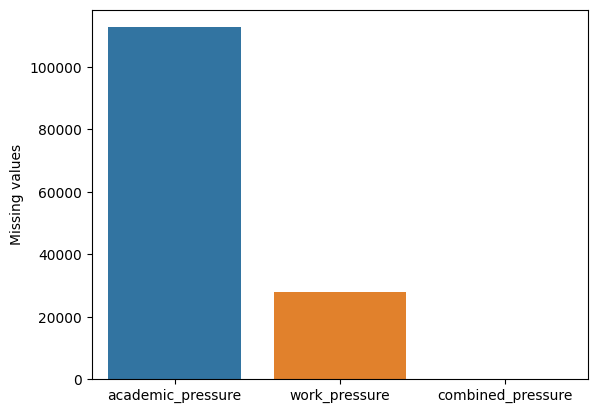

In [4]:
academic_pressure_missing_values = X.loc[X.Academic_Pressure.isnull()]
work_pressure_missing_values = X.loc[X.Work_Pressure.isnull()]
pressure_missing_values = X.loc[X.Academic_Pressure.isnull() & X.Work_Pressure.isnull()]

print('number of missing values on the combined "pressure" column: ', len(pressure_missing_values))

sns.barplot(
    x=["academic_pressure", "work_pressure", "combined_pressure"], 
    y=[len(academic_pressure_missing_values), len(work_pressure_missing_values), len(pressure_missing_values)]
)
plt.ylabel("Missing values")

number of missing values on the combined "satisfaction" column:  15


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


Text(0, 0.5, 'Missing values')

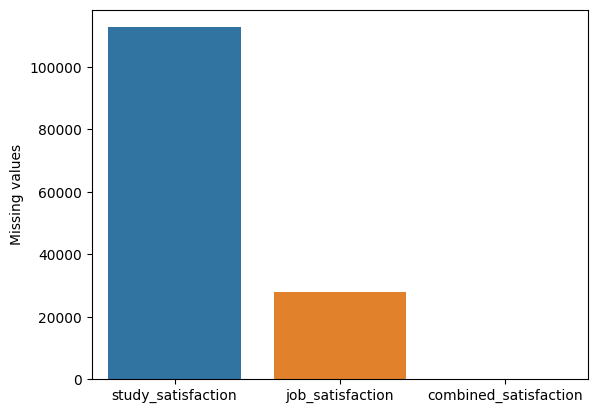

In [5]:
study_satisfaction_missing_values = X.loc[X.Study_Satisfaction.isnull()]
job_satisfaction_missing_values = X.loc[X.Job_Satisfaction.isnull()]
satisfaction_missing_values = X.loc[X.Study_Satisfaction.isnull() & X.Job_Satisfaction.isnull()]
print('number of missing values on the combined "satisfaction" column: ', len(satisfaction_missing_values))

sns.barplot(
    x=["study_satisfaction", "job_satisfaction", "combined_satisfaction"], 
    y=[len(study_satisfaction_missing_values), len(job_satisfaction_missing_values), len(satisfaction_missing_values)]
)
plt.ylabel("Missing values")

By joining "satisfaction" and "pressure" columns, we could greatlty reduce the number of missing values.<br>
Being a 1 to 5 scale, remaining missing data could be filled with a "neutral" score of 3.

number of missing professions:  36630
number of missing profession when the person is not a student:  8763
number of students with a profession:  34


([<matplotlib.patches.Wedge at 0x78563c7c3370>,
 [Text(-0.8036844461683476, 0.7510601247483962, 'students without profession'),
  Text(0.8036845516473256, -0.7510600118788361, 'professionals without profession')],
 [Text(-0.43837333427364406, 0.4096691589536707, '76%'),
  Text(0.4383733918076321, -0.40966909738845597, '24%')])

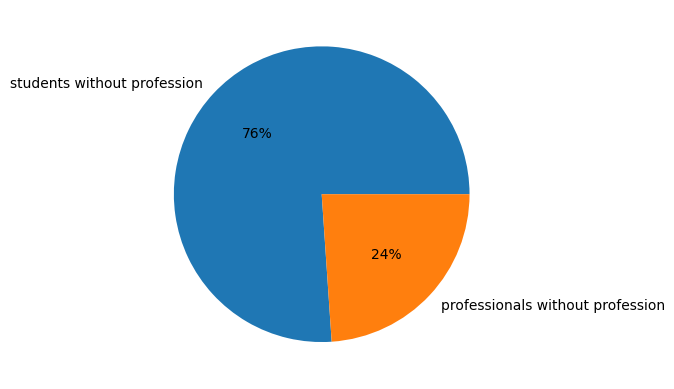

In [6]:
profession_missing_values = len(X.loc[X.Profession.isnull()])
profession_missing_values_students = len(X.loc[X.Profession.isnull() & (X.Working_Professional_or_Student == 'Student')])
profession_missing_values_not_students = len(X.loc[X.Profession.isnull() & (X.Working_Professional_or_Student == 'Working Professional')])
profession_provided_on_students = len(X.loc[X.Profession.notnull() & (X.Working_Professional_or_Student == 'Student')])

print('number of missing professions: ', profession_missing_values)
print('number of missing profession when the person is not a student: ', profession_missing_values_not_students)
print('number of students with a profession: ', profession_provided_on_students)

plt.pie(
[
    profession_missing_values_students*100/profession_missing_values, 
    profession_missing_values_not_students*100/profession_missing_values
], 
labels = ["students without profession", "professionals without profession"], 
autopct='%.0f%%'
)

76% of missing profession values come from students that do not work.

number of missing cgpa:  112802
number of students with missing cgpa:  9
number of professionals with missing cgpa:  112793
number of professionals with cgpa:  6


([<matplotlib.patches.Wedge at 0x78563c826170>,
 [Text(1.0999999654447683, 0.00027571998252839334, 'students without CGPA'),
  Text(-1.0999999654662498, -0.00027563426696066383, 'professionals without CGPA')],
 [Text(0.5999999811516917, 0.00015039271774276, '0%'),
  Text(-0.5999999811634089, -0.0001503459637967257, '100%')])

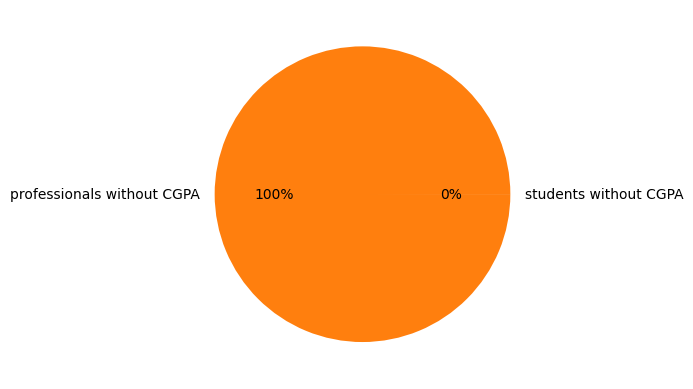

In [7]:
cgpa_missing_values = len(X.loc[X.CGPA.isnull()])
cgpa_students_missing_values = len(X.loc[X.CGPA.isnull() & (X.Working_Professional_or_Student == 'Student')])
cgpa_professional_missing_values = len(X.loc[X.CGPA.isnull() & (X.Working_Professional_or_Student == 'Working Professional')])
cgpa_professional = len(X.loc[X.CGPA.notnull() & (X.Working_Professional_or_Student == 'Working Professional')])

print('number of missing cgpa: ', cgpa_missing_values)
print('number of students with missing cgpa: ', cgpa_students_missing_values)
print('number of professionals with missing cgpa: ', cgpa_professional_missing_values)
print('number of professionals with cgpa: ', cgpa_professional)

plt.pie(
[
    cgpa_students_missing_values*100/cgpa_missing_values, 
    cgpa_professional_missing_values*100/cgpa_missing_values
], 
labels = ["students without CGPA", "professionals without CGPA"], 
autopct='%.0f%%'
)

almost all CGPA missing values come from professionals

In [8]:
# Categorical values
print('Sleep duration:',X['Sleep_Duration'].unique())
print('Professions:',X['Profession'].unique())
print('Diets:',X['Dietary_Habits'].unique())
print('Degrees:',X['Degree'].unique())
print('Gender:',X['Gender'].unique())
print('Thoughts:',X['Have_you_ever_had_suicidal_thoughts_'].unique())
print('Working:',X['Working_Professional_or_Student'].unique())
print('History:',X['Family_History_of_Mental_Illness'].unique())

Sleep duration: ['More than 8 hours' 'Less than 5 hours' '5-6 hours' '7-8 hours'
 'Sleep_Duration' '1-2 hours' '6-8 hours' '4-6 hours' '6-7 hours'
 '10-11 hours' '8-9 hours' '40-45 hours' '9-11 hours' '2-3 hours'
 '3-4 hours' 'Moderate' '55-66 hours' '4-5 hours' '9-6 hours' '1-3 hours'
 'Indore' '45' '1-6 hours' '35-36 hours' '8 hours' 'No' '10-6 hours'
 'than 5 hours' '49 hours' 'Unhealthy' 'Work_Study_Hours' '3-6 hours'
 '45-48 hours' '9-5' 'Pune' '9-5 hours']
Professions: ['Chef' 'Teacher' nan 'Business Analyst' 'Finanancial Analyst' 'Chemist'
 'Electrician' 'Software Engineer' 'Data Scientist' 'Plumber'
 'Marketing Manager' 'Accountant' 'Entrepreneur' 'HR Manager'
 'UX/UI Designer' 'Content Writer' 'Educational Consultant'
 'Civil Engineer' 'Manager' 'Pharmacist' 'Financial Analyst' 'Architect'
 'Mechanical Engineer' 'Customer Support' 'Consultant' 'Judge'
 'Researcher' 'Pilot' 'Graphic Designer' 'Travel Consultant'
 'Digital Marketer' 'Lawyer' 'Research Analyst' 'Sales Executive' 

There are quite some noisy values on categorical columns, i must say that i'd follow an `Electrician` diet too if i was working as an `Unveil`.

## Define a pipeline
`MentalHealthDTPipeline` pipeline from repo does the same thing as the following code:

#### categoricals dictionaries definition

In [9]:
sleep_dictionary = {
    '0': 0,
    'No': 0,
    '1-2 hours': 1.5,
    '1-3 hours': 2,
    '2-3 hours': 2.5,
    '20-21 hours': 2.5,  # probably per week
    'Unhealthy': 3,
    '3-4 hours': 3.5,
    '3-6 hours': 3.5,
    '1-6 hours': 4,
    'Less than 5 hours': 4,
    '4-5 hours': 4.5,
    '4-6 hours': 5,
    '35-36 hours': 5,  # probably per week
    '5-6 hours': 5.5,
    'Moderate': 6,
    '45': 6,  # probably per week
    '40-45 hours': 6,  # probably per week
    '6-7 hours': 6.5,
    '45-48 hours': 6.5,  # probably per week
    '6-8 hours': 7,
    '9-5': 7,
    '9-5 hours': 7,
    '49 hours': 7,  # probably per week
    '7-8 hours': 7.5,
    '9-6 hours': 7.5,
    '8 hours': 8,
    '10-6 hours': 8,
    '55-66 hours': 8.5,  # probably per week
    '8-89 hours': 8.5,  # probably typo
    '8-9 hours': 8.5,
    '50-75 hours': 8.5,  # probably per week
    'More than 8 hours': 9,
    '60-65 hours': 9,  # probably per week
    '9-11 hours': 10,
    '10-11 hours': 10.5,
}

diet_dictionary = {
    'More Healty': 0,
    'Healthy': 1,
    '5 Healthy': 1,
    'Mealy': 2,
    'Less than Healthy': 2,
    'Less Healthy': 2,
    'Moderate': 3,
    '5 Unhealthy': 4,
    'Unhealthy': 4,
    'No Healthy': 4,
}

gender_dictionary = {
    'Male': 0,
    'Female': 1,
}

student_profession_dictionary = {
    'Working Professional': 1,
    'Student': 0,
}

yes_no_dictionary = {
    'No': 0,
    'Yes': 1,
}

cols_profession_to_delete = [
    'PhD', 'MBBS', 'B.Ed', 'M.Ed', 'BBA', 'MBA', 'LLM', 'BCA', 'B.Com', 'BE', 'Simran', '3M',
    'Name', 'No', '24th', 'Unveil', 'Unhealthy', 'Yuvraj', 'Yogesh', 'Patna', 'Nagpur',
    'Pranav', 'Visakhapatnam', 'Moderate', 'Manvi', 'Yogesh', 'Samar', 'Surat'
]

#### column null values handling

In [10]:
# delete weird professions
X['Profession'] = X['Profession'].mask(X['Profession'].isin(cols_profession_to_delete))

# create "student" profession (disabled, confuses the model)
# X.loc[(X['Working_Professional_or_Student'] == 'Student') & (X['Profession'].isnull()), 'Profession'] = 'Student'

# merge satisfaction and pressure columns and 0fill remainings (disabled, confuses the model)
# X['Satisfaction'] = X['Study_Satisfaction'].fillna(X['Job_Satisfaction'])
# X['Pressure'] = X['Academic_Pressure'].fillna(X['Work_Pressure'])
# X['Satisfaction'] = X['Satisfaction'].fillna(0)
# X['Pressure'] = X['Pressure'].fillna(0)
#X.drop(['Study_Satisfaction'], axis=1, inplace=True)
#X.drop(['Job_Satisfaction'], axis=1, inplace=True)
#X.drop(['Academic_Pressure'], axis=1, inplace=True)
#X.drop(['Work_Pressure'], axis=1, inplace=True)

# fill metric numericals with values that make sense (eg: if working, then no study stress)
X['Academic_Pressure'] = X['Academic_Pressure'].fillna(0)
X['Work_Pressure'] = X['Work_Pressure'].fillna(0)
X['Study_Satisfaction'] = X['Study_Satisfaction'].fillna(0)
X['Job_Satisfaction'] = X['Job_Satisfaction'].fillna(0)
X['CGPA'] = X['CGPA'].fillna(-1)  # we want to emphasize that it's a missing value
X['Financial_Stress'] = X['Financial_Stress'].fillna(-1)  # we want to emphasize that it's a missing value

# fill unknown categoricals
X['Profession'] = X['Profession'].fillna('Unknown')
X['Dietary_Habits'] = X['Dietary_Habits'].fillna('Unknown')
X['Degree'] = X['Degree'].fillna('Unknown')

# Assign values based on the dictionaries and set -1 for empty values
X['Sleep_Duration'] = X['Sleep_Duration'].apply(lambda x: sleep_dictionary.get(x, -1) if x != '' else -1)
X['Dietary_Habits'] = X['Dietary_Habits'].apply(lambda x: diet_dictionary.get(x, -1) if x != '' else -1)
X['Gender'] = X['Gender'].apply(lambda x: gender_dictionary.get(x, -1) if x != '' else -1)
X['Have_you_ever_had_suicidal_thoughts_'] = X['Have_you_ever_had_suicidal_thoughts_'].apply(lambda x: yes_no_dictionary.get(x, -1) if x != '' else -1)
X['Working_Professional_or_Student'] = X['Working_Professional_or_Student'].apply(lambda x: student_profession_dictionary.get(x, -1) if x != '' else -1)
X['Family_History_of_Mental_Illness'] = X['Family_History_of_Mental_Illness'].apply(lambda x: yes_no_dictionary.get(x, -1) if x != '' else -1)

#### Additional features

In [11]:
def compute_hours_column(row, professional):
    if row['Working_Professional_or_Student'] == professional:
        return row['Work_Study_Hours']
    else:
        return 0

def compute_work_stress_column(row):
    if row['Working_Professional_or_Student'] == 1:
        return row['Financial_Stress'] + row['Work_Pressure'] - row['Job_Satisfaction']
    else:
        return 0

def compute_academic_stress_column(row):
    if row['Working_Professional_or_Student'] == 0:
        return row['Financial_Stress'] + row['Academic_Pressure'] - row['Study_Satisfaction']
    else:
        return 0

# create additional stress columns (disabled, does not improve CV)
# X['Work_Stress'] = X.apply(lambda row: compute_work_stress_column(row), axis=1)
# X['Academic_Stress'] = X.apply(lambda row: compute_academic_stress_column(row), axis=1)

# distinct study and work hours
# X['Work_Hours'] = X.apply(lambda row: compute_hours_column(row, 1), axis=1)
# X['Study_Hours'] = X.apply(lambda row: compute_hours_column(row, 0), axis=1)

#X.drop(['Work_Study_Hours'], axis=1, inplace=True)

#### fix uneven names

In [12]:
def fix_name(degree):
    # if it's not a string, do nothing
    if not isinstance(degree, str):
        return degree

    # remove special characters
    degree = re.sub('[^A-Za-z0-9_]+', '', degree)

    # lowercase
    degree = degree.lower()

    return degree

# standardize names to avoid duplicates and misspellings
X['Degree'] = X['Degree'].apply(fix_name)
X['Profession'] = X['Profession'].apply(fix_name)

In [13]:
features_with_missing_values = [col for col in X.columns if X[col].isnull().any()]

print('number of columns with missing values: ', len(features_with_missing_values))
print(features_with_missing_values)
print('--- Percentage of Missing Values ---')
print(100*X[features_with_missing_values].isnull().sum() / X.shape[0])

number of columns with missing values:  0
[]
--- Percentage of Missing Values ---
Series([], dtype: float64)


In [14]:
# reload data to use pipeline
X, y = load_data()
pipeline = MentalHealthDTPipeline(X, True)

### Train model 

In [15]:
model_type = XGBClassifierWrapper()
trainer = CachedAccurateCrossTrainer(pipeline, model_type, X, y, metric=AccuracyMetric.AUC)
# optimizer = CustomGridOptimizer(trainer, model_type, direction=OptimizationDirection.MAXIMIZE)
optimized_params = {
    'objective': 'binary:logistic', 
    'eval_metric': 'auc', 
    'learning_rate': 0.03, 
    'max_depth': 5, 
    'min_child_weight': 5, 
    'gamma': 0.3, 
    'subsample': 0.6, 
    'colsample_bytree': 0.7, 
    'scale_pos_weight': 1, 
    'n_jobs': -1, 
    'reg_alpha': 0
}


_, iterations = trainer.validate_model(X, y, log_level=1, params=optimized_params)

Cross-Validation AUC: 0.9752294039348401
Optimal Boosting Rounds:  354
Generating AUC with optimal boosting rounds
Cross-Validation AUC: 0.9752253627163725
Optimal Boosting Rounds:  354


                                        feats  importance
0                                    num__Age    0.272376
1   cat__Have_you_ever_had_suicidal_thoughts_    0.240610
2                      num__Academic_Pressure    0.133769
3        cat__Working_Professional_or_Student    0.108122
4                       num__Financial_Stress    0.050012
5                       num__Job_Satisfaction    0.038715
6                          num__Work_Pressure    0.038124
7                             cat__Profession    0.031847
8                         cat__Dietary_Habits    0.022023
9                       num__Work_Study_Hours    0.019515
10                        cat__Sleep_Duration    0.012279
11                    num__Study_Satisfaction    0.011931
12                                  num__CGPA    0.006259
13      cat__Family_History_of_Mental_Illness    0.005325
14                                cat__Degree    0.005106
15                                cat__Gender    0.003986


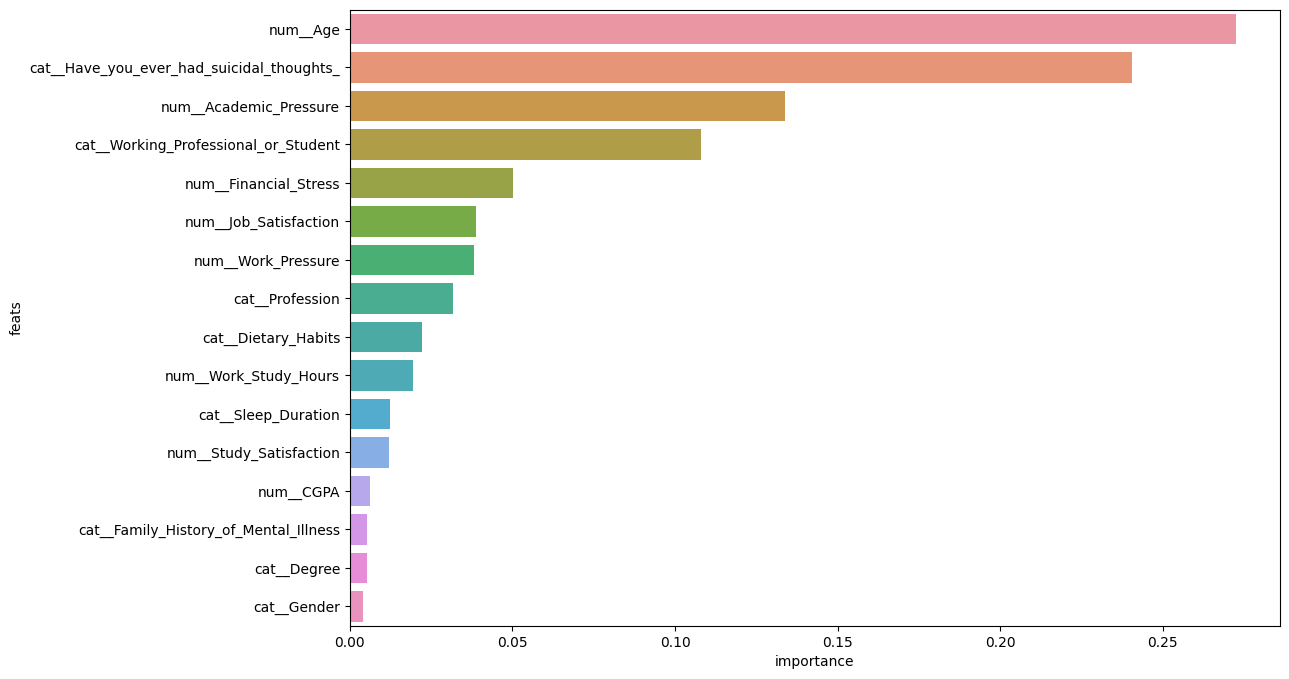

In [16]:
trainer.show_feature_importance(X)

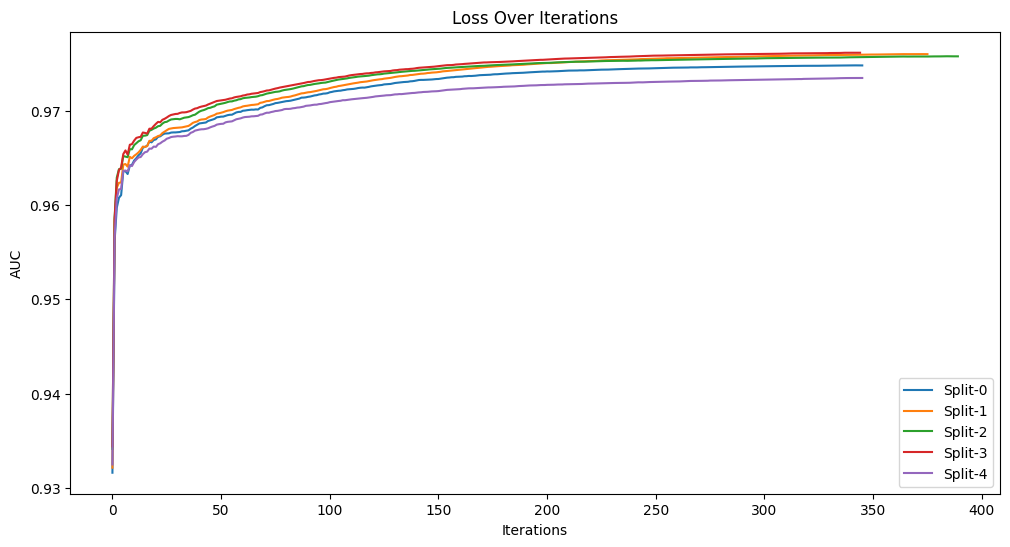

In [17]:
trainer.show_loss()

## Train complete model on all data

In [18]:
complete_model = trainer.train_model(X, y, iterations=iterations, params=optimized_params)

## Make predictions on the competition data, and generate submission

In [19]:
# Load the data
test_data_path = '/kaggle/input/playground-series-s4e11/test.csv'
test_data = pd.read_csv(test_data_path, index_col='id')

# drop useless columns
test_data.drop(['Name'], axis=1, inplace=True)
test_data.drop(['City'], axis=1, inplace=True)

# standardize column names
test_data = test_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

processed_test_data = pipeline.transform(test_data)

# make predictions which we will submit. 
test_preds = complete_model.predict(processed_test_data)

# Save predictions in the format used for competition scoring
output = pd.DataFrame({'id': test_data.index,
                       'Depression': test_preds})
output.to_csv('submission.csv', index=False)